In [1]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet(sample_in,sample_out,data_mode='sparse',data_ondisk=False)
dl.config = args
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/hbcc/hbcc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/hbcc/hbcc


In [2]:
model = np.load(sample_out+'_altnmf.npz')

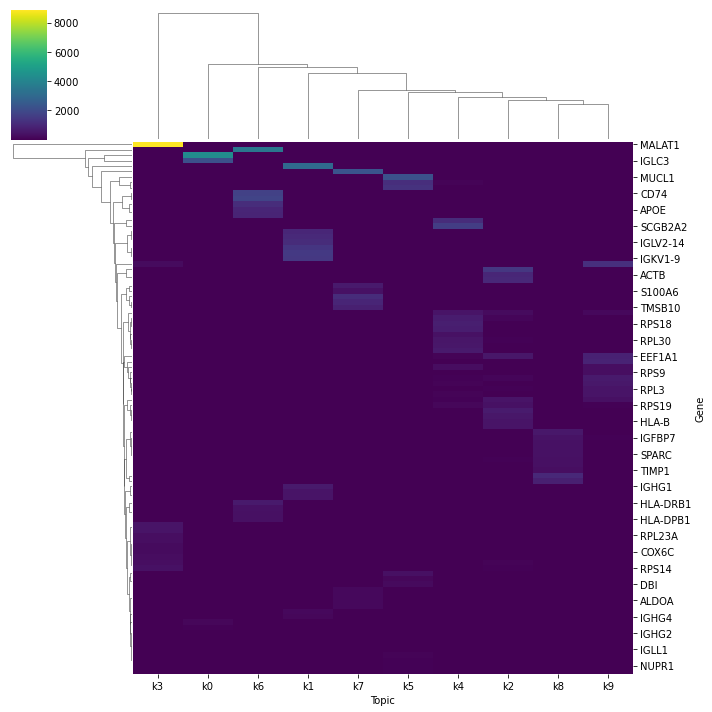

In [3]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

In [45]:
import umap
df_theta = pd.DataFrame(model['corr'])
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.2,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic_bulk,umap1,umap2
0,CID3586_AAGACCTCAGCATGAG,2,7.235559,13.400717
1,CID3586_AAGGTTCGTAGTACCT,2,7.375309,13.155181
2,CID3586_ACCAGTAGTTGTGGCC,2,7.200254,13.075492
3,CID3586_ACCCACTAGATGTCGG,2,7.182860,12.876945
4,CID3586_ACTGATGGTCAACTGT,9,6.223128,13.903308
...,...,...,...,...
100059,CID4398_TCAGGTAGTACTCAAC,2,14.198146,5.769736
100060,CID4398_TCTATTGTCGCCATAA,3,-3.938586,13.626612
100061,CID4398_TCTTTCCCAGTAAGCG,2,-2.813269,-0.940497
100062,CID4398_TGCCCATGTTACGGAG,3,-3.984850,13.495284


Text(0, 0.5, 'UMAP2')

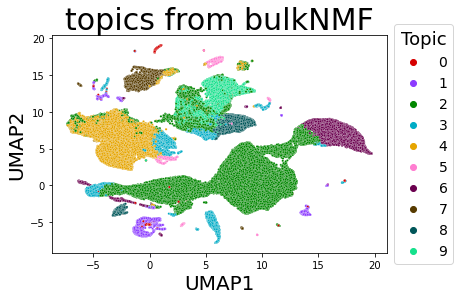

In [46]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

In [47]:
df_pl = pd.read_csv(dl.inpath+'_metadata.csv')
df_pl = df_pl.loc[:,['Unnamed: 0','celltype_major']]
df_pl.columns = ['cell','cell_type']
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')


Text(0, 0.5, 'UMAP2')

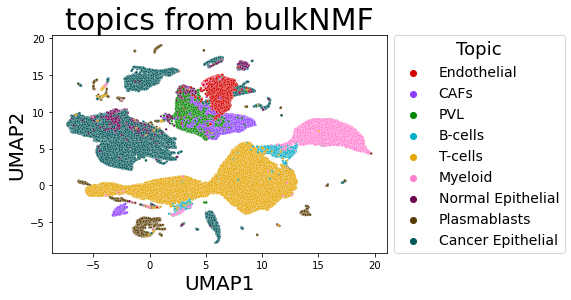

In [48]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

In [49]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match


cell                                                    \
topic_bulk             0       1        2       3        4       5       6   
cell_type                                                                    
B-cells             20.0    37.0   3025.0    85.0      4.0     0.0    35.0   
CAFs                 4.0     7.0   1512.0   331.0     16.0     7.0     8.0   
Cancer Epithelial    1.0    24.0    775.0  3415.0  14363.0  1181.0     6.0   
Endothelial          9.0     9.0    785.0   254.0      1.0     0.0     9.0   
Myeloid              2.0     6.0   1998.0    91.0      3.0     0.0  7544.0   
Normal Epithelial    0.0     0.0   1743.0   112.0   2354.0    90.0     1.0   
PVL                  6.0     3.0   1420.0   478.0      8.0     0.0     4.0   
Plasmablasts       242.0  2658.0    120.0     4.0      9.0    15.0   458.0   
T-cells              9.0    81.0  33788.0  1298.0     12.0     0.0    21.0   

                                           
topic_bulk              7       8       9  
cell_type                                  
B-cells               0.0     0.0     0.0  
CAFs                  0.0  3932.0   756.0  
Cancer Epithelial  3686.0    13.0  1025.0  
Endothelial           2.0     0.0  6536.0  
Myeloid               0.0     0.0    31.0  
Normal Epithelial     3.0     0.0    52.0  
PVL                   1.0   198.0  3305.0  
Plasmablasts          4.0     4.0    10.0  
T-cells               1.0     0.0     4.0

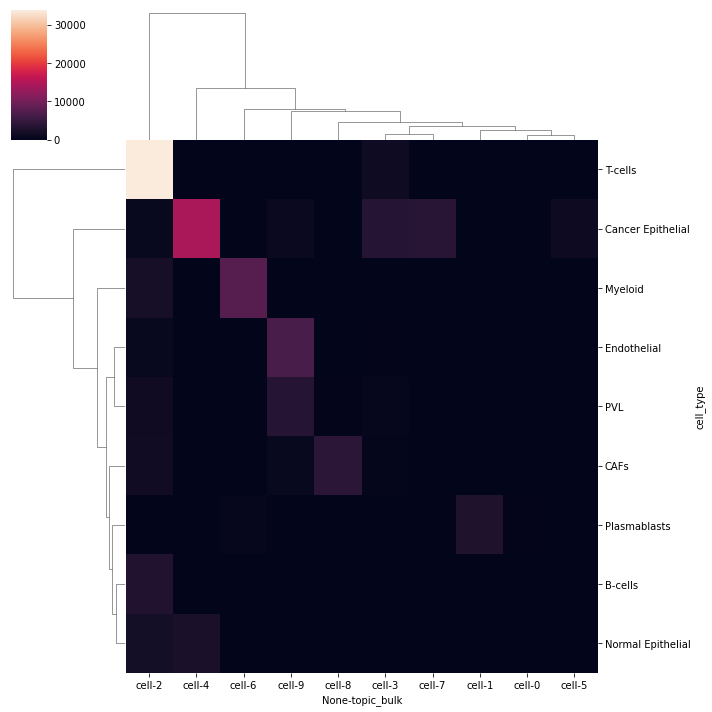

In [50]:
sns.clustermap(df_match)

In [51]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)

0.5817064409117667